## Define path to trained model

In [1]:
# Trained model path
model_path = '/Users/apple/Resnet_trained_models/resnet50_csv_20.h5'

## Check for required keras version

In [ ]:
# Check keras version
!python -c 'import keras; print(keras.__version__)'

In [ ]:
# Install Keras version 2.3.0 or above, if required
# !pip install Keras==2.3.1

## Clone Retinanet Repo

In [ ]:
import os

repo_url = 'https://github.com/ijeism/keras-retinanet'
# forked from 'fizyr/keras-retinanet'

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url))) # define repo directory path

!git clone {repo_url} # clone repo
%cd {repo_dir_path} 
!git pull # pull repo

In [ ]:
# Make necessary installations

# from /content/keras-retinanet
!pip install .
!python setup.py build_ext --inplace

## Import required modules

In [2]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
THRES_SCORE = 0.5

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.set_session(get_session())

## Convert training model to inference model

In [ ]:
#!keras_retinanet/bin/convert_model.py /Users/apple/Resnet_trained_models/resnet50_csv_20.h5 /Users/apple/Resnet_trained_models/inference_model.h5

## Image inference function

In [3]:
INFERENCE_MODEL = '/Users/apple/Resnet_trained_models/inference_model.h5'
model = models.load_model(INFERENCE_MODEL, backbone_name='resnet50')
labels_to_names = {0: 'car', 1: 'pool'}

Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


/Users/apple/.pyenv/versions/3.7.0/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def img_inference(path):
    
    THRES_SCORE = 0.5

    #load image
    image = read_image_bgr(path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    (image, scale) = resize_image(image)
    image = np.expand_dims(image, axis=0)

    # process image and correct for image scale
    start = time.time()
    (boxes, scores, labels) = model.predict_on_batch(image)
    print("processing time: ", time.time() - start)
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < THRES_SCORE:
            print('Found a bounding box at {0:.2%}. Box did not meet threshold'.format(score))
            break
        else:
            print('Found a bounding box at {0:.2%}. Box met threshold'.format(score))

            
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

    #     caption = "{} {:.3f}".format(labels_to_names[label], score)
    #     draw_caption(draw, b, caption)

    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

## Inspect inferenced test images

processing time:  4.3580427169799805
Found a bounding box at 88.27%. Box met threshold
Found a bounding box at 77.43%. Box met threshold
Found a bounding box at 58.33%. Box met threshold
Found a bounding box at 50.30%. Box met threshold
Found a bounding box at 17.92%. Box did not meet threshold


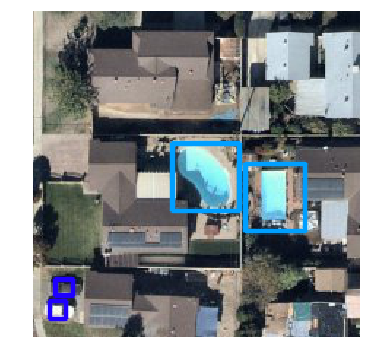

processing time:  3.7734408378601074
Found a bounding box at 88.37%. Box met threshold
Found a bounding box at 74.41%. Box met threshold
Found a bounding box at 63.63%. Box met threshold
Found a bounding box at 62.87%. Box met threshold
Found a bounding box at 57.40%. Box met threshold
Found a bounding box at 53.33%. Box met threshold
Found a bounding box at 41.63%. Box did not meet threshold


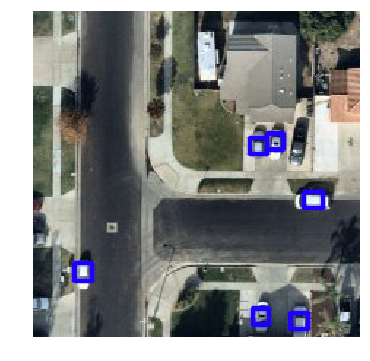

processing time:  3.704763889312744
Found a bounding box at 64.81%. Box met threshold
Found a bounding box at 57.07%. Box met threshold
Found a bounding box at 25.98%. Box did not meet threshold


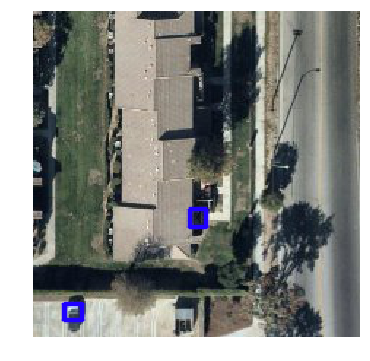

processing time:  3.7755119800567627
Found a bounding box at 41.50%. Box did not meet threshold


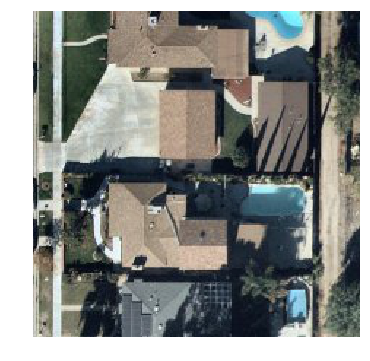

processing time:  3.740334987640381
Found a bounding box at 88.55%. Box met threshold
Found a bounding box at 81.08%. Box met threshold
Found a bounding box at 79.41%. Box met threshold
Found a bounding box at 79.27%. Box met threshold
Found a bounding box at 68.14%. Box met threshold
Found a bounding box at 64.90%. Box met threshold
Found a bounding box at 55.48%. Box met threshold
Found a bounding box at 39.19%. Box did not meet threshold


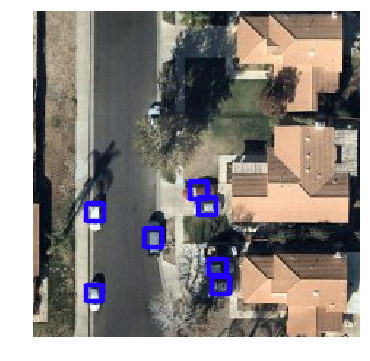

processing time:  3.648099899291992
Found a bounding box at 84.41%. Box met threshold
Found a bounding box at 80.25%. Box met threshold
Found a bounding box at 75.73%. Box met threshold
Found a bounding box at 60.14%. Box met threshold
Found a bounding box at 27.60%. Box did not meet threshold


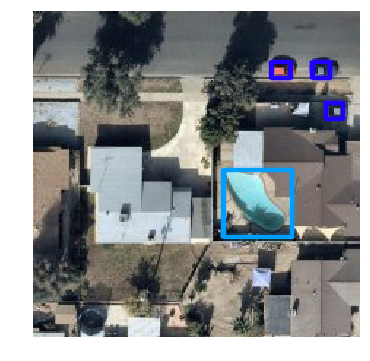

In [5]:
import glob

validation_path = '/Users/apple/Downloads/swimming-pool-and-car-detection/test_data_images/sample_test/'
test_images = [os.path.join(validation_path, file) for file in glob.glob(validation_path + '*.jpg')]

for path in test_images:
    img_inference(path)

## Save inferenced test images

In [8]:
# save inferenced images 

# create output directory for images with bounding boxes
!mkdir /Users/apple/ijeism_retinanet/output

# run code
!python /Users/apple/ijeism_retinanet/image_inference_print.py \
-i '/Users/apple/Downloads/swimming-pool-and-car-detection/test_data_images/sample_test/' \
-t 0.6 \
-m '/Users/apple/Resnet_trained_models/inference_model.h5' \
-o '/Users/apple/ijeism_retinanet/output'

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
2019-11-07 14:24:42.704148: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
/Users/apple/.pyenv/versions/3.7.0/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
Traceback (most recent call last):
  File "/Users/apple/ijeism_retinanet/image_inference_print.py",

## Create annoation files for inferenced images

In [12]:
!python /Users/apple/ijeism_retinanet/image_inference_write.py -h

Using TensorFlow backend.
usage: image_inference_write.py [-h] -i INPUT_DIR [-t THRESHOLD] -m MODEL -o
                                OUTPUT_DIR -l LABELS

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT_DIR, --input_dir INPUT_DIR
                        dir path to inference images
  -t THRESHOLD, --threshold THRESHOLD
                        threshold for filtering weak detections
  -m MODEL, --model MODEL
                        path to trained/converted model
  -o OUTPUT_DIR, --output_dir OUTPUT_DIR
                        path to output directory
  -l LABELS, --labels LABELS
                        path to class csv


In [36]:
# create output directory for images with bounding boxes
# !mkdir /Users/apple/ijeism_retinanet/output

# run code
!python /Users/apple/ijeism_retinanet/image_inference_write.py \
-i '/Users/apple/Downloads/swimming-pool-and-car-detection/test_data_images/sample_test/' \
-t 0.6 \
-m '/Users/apple/Resnet_trained_models/inference_model.h5' \
-o '/Users/apple/ijeism_retinanet/output/' \
-l '/Users/apple/ijeism_retinanet/trial/classes.csv'

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
2019-11-07 15:01:48.318888: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
/Users/apple/.pyenv/versions/3.7.0/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
[INFO] predicting image 1 of 6
processing time:  4.113303184509277
[INFO] predicting image 2 of 6
p

In [37]:
# delete created directories
!rm -R '/Users/apple/ijeism_retinanet/output'
!rm -R '/Users/apple/ijeism_retinanet/trial'